# Deterministic Variational Inference: Toy example
Code to accompany [**Fixing Variational Bayes: Deterministic Variational Inference for Bayesian Neural Networks**](https://arxiv.org/abs/1810.03958)

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os, json 

import gaussian_variables as gv
import utils as u
import plot_utils as pu
import bayes_layers as bnn
from bayes_models import MLP, PointMLP, AdaptedMLP

np.random.seed(3)

## Dataset

First we generate a toy dataset according to:

\begin{equation}
    y = -(x+0.5)\sin(3\pi x) + \eta
\end{equation}

Where the noise is generated according to:

\begin{equation}
    \eta = 0.45(x + 0.5)^2
\end{equation}

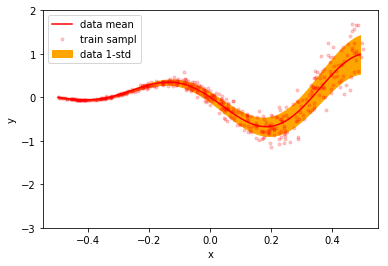

In [2]:
def base_model(x):
    return -(x+0.5)*np.sin(3 * np.pi *x)

def noise_model(x):
    return 0.45*(x+0.5)**2

def sample_data(x):
    return base_model(x) + np.random.normal(0, noise_model(x))

data_size = {'train': 500, 'valid': 100, 'test': 100}
toy_data = []
for section in ['train', 'valid', 'test']:
    x = (np.random.rand(data_size['train'], 1) - 0.5)
    toy_data.append([x, sample_data(x).reshape(-1)])    
x = np.arange(-1,1,1/100)
toy_data.append([[[_] for _ in x], base_model(x)])

pu.toy_results_plot(toy_data, {'mean':base_model, 'std':noise_model})

# Model

Here we set the hyperparameters and provide a function for constructing a Bayesian Neural Network.

In [3]:
hypers = {
    "x_dim": 1,                                "y_dim": 2,
    "hidden_dims": [128,128],                  "nonlinearity": "relu",
    "adapter": {
        'in' : {"scale": [[1.0]], "shift": [[0.0]]},
        'out': {"scale": [[1.0, 0.83]], "shift": [[0.0, -3.5]]}
    },
    
    "method": "bayes",                         "style": "heteroskedastic",
    "homo_logvar_scale": 2*np.log(0.2),        "prior_type": ["empirical", "wider_he", "wider_he"],
    
    "n_epochs": 20000,                         "batch_size": 500,
    "learning_rate": 0.001,                    "lambda": 1.0,
    "warmup_updates": {'lambda': 14000.0},     "anneal_updates": {'lambda': 1000.0},
    "optimizer": "adam",                       "gradient_clip": 0.1,

    "data_fraction": 1.0,                      "sections_to_run": ["train"]
}

In [4]:
def make_model(hypers):
    if hypers['method'].lower().strip() == 'bayes':
        MLP_factory = MLP
        prediction = lambda y: tf.reshape(y.mean[:,0], [-1])
        loss = bnn.regression_loss
    else:
        MLP_factory = PointMLP
        prediction = lambda y: tf.reshape(y.mean[:,0], [-1])
        loss = bnn.point_regression_loss
        
    mlp = MLP_factory(hypers['x_dim'], hypers['y_dim'], hypers)
    mlp = AdaptedMLP(mlp)
    mlp.make_placeholders()
    ipt = mlp.placeholders['ipt_mean']
    y = mlp(ipt)

    target = tf.placeholder(tf.float32, [None])
    mlp.placeholders['target'] = target
    global_step = tf.Variable(0, trainable=False, name='global_step')
    loss, logprob, all_surprise = loss(y, target, mlp, hypers, global_step)

    accuracy = tf.reduce_mean(tf.abs(target - prediction(y)))
    
    return {
        'model': mlp,
        'metrics': {
            'accuracy': accuracy,   'loss': loss,
            'logprob': logprob,     'all_surprise': all_surprise
            },
        'global_step': global_step}

## Training loop

For the first `warmup_updates` epochs we run with the KL term in the elbo turned off. You will observe that the model starts to overfit the data. The KL term is then ramped back on and the model is trained with the full ELBO to convergence.

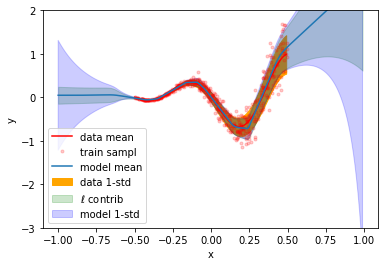

Epoch 19820:         train accuracy = 0.1140 | logprob = 1.1212 | KL term = 1.122166015625
Epoch 19840:         train accuracy = 0.1140 | logprob = 1.1213 | KL term = 1.1220546875
Epoch 19860:         train accuracy = 0.1140 | logprob = 1.1214 | KL term = 1.1219482421875
Epoch 19880:         train accuracy = 0.1140 | logprob = 1.1215 | KL term = 1.1218447265625
Epoch 19900:         train accuracy = 0.1140 | logprob = 1.1215 | KL term = 1.1217442626953125
Epoch 19920:         train accuracy = 0.1140 | logprob = 1.1216 | KL term = 1.121634765625
Epoch 19940:         train accuracy = 0.1140 | logprob = 1.1217 | KL term = 1.1215399169921876
Epoch 19960:         train accuracy = 0.1140 | logprob = 1.1218 | KL term = 1.1214420166015624
Epoch 19980:         train accuracy = 0.1140 | logprob = 1.1219 | KL term = 1.1213468017578125


In [5]:
run_id = u.start_run()

data = toy_data

restricted_training_set = u.restrict_dataset_size(data[0], hypers['data_fraction'])
hypers['dataset_size'] = len(restricted_training_set[0])

device_id = 0
device_string = u.get_device_string(device_id)
print(hypers)
with tf.device(device_string):
    if True:
        model_and_metrics = make_model(hypers)
        train_op = u.make_optimizer(model_and_metrics, hypers)
        sess = u.get_session()
        saver = tf.train.Saver()

        all_summaries = []
        best_valid_accuracy = np.inf
    
    for epoch in range(hypers['n_epochs']):
        verbose = (epoch % 20 == 0)
        if verbose:
            print("Epoch %i:        " % epoch, end='')
        epoch_summary, accuracies = u.train_valid_test(
            {
                'train': restricted_training_set,
                'valid': data[1],
                'test': data[2]
            },
            sess, model_and_metrics, train_op, hypers, verbose)

        if epoch % 200 == 0:
            clear_output()
            predictions = u.get_predictions(data[3], sess, model_and_metrics['model'], hypers)
            pu.toy_results_plot(toy_data, {'mean':base_model, 'std':noise_model}, hypers, predictions)
            plt.show()

        # dump log file
        all_summaries.append(epoch_summary)
        #with open(os.path.join("logs", run_id, "results.json"), 'w') as f:
        #    json.dump(all_summaries, f, indent=4, cls=u.NumpyEncoder)

## Comparison with MC

We compare the output activations of the BNN as predicted using our deterministic approximation with the activations predicted by Monte Carlo approximation (see Figure 3 of the paper)

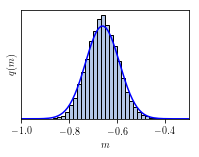

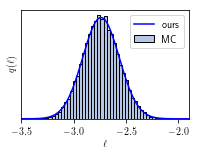

In [6]:
from matplotlib import rc
rc('text', usetex=True)

n_samp = 20000
x=0.25
ipt = [[[x]] for _ in range(n_samp)]
sample_op = model_and_metrics['model'].run_with_MC(ipt, n_sample=n_samp)
approx_op = model_and_metrics['model'](x)

samples = sess.run(sample_op)
approx = sess.run([approx_op.mean, approx_op.var])

def gaussian1d(mean, var):
    x_axis = np.linspace(-5,5,1000)
    return x_axis, 1.0 / np.sqrt(2.0 * np.pi * var) * np.exp(-1.0 / (2.0 * var) * (x_axis - mean)**2)


samples.shape
plt.figure(figsize=(3,2))
plt.hist(samples[:,0,0], int(np.round(200/(1-0.3))), density=True, edgecolor='k', facecolor='#b4c7e7')
plt.plot(*gaussian1d(approx[0][0,0], approx[1][0,0,0]), 'b')
plt.xlim([-1,-0.3])
plt.yticks([])
plt.xlabel('$m$')
plt.ylabel('$q(m)$')
plt.show()

plt.figure(figsize=(3,2))
plt.hist(samples[:,0,1], int(np.round(200/(3.5-1.9))), density=True, edgecolor='k', facecolor='#b4c7e7', label="MC")
plt.plot(*gaussian1d(approx[0][0,1], approx[1][0,1,1]), 'b', label="ours")
plt.xlim([-3.5,-1.9])
plt.yticks([])
plt.xlabel('$\ell$')
plt.ylabel('$q(\ell)$')
plt.legend()
plt.show()